**Initial step:** Please try to put the extracted heavy_makeup_CelebA folder in 

*   List item
*   List item

your Google Drive!
So now you could mount your data to this ipynb!

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# if you mount Google drive correctly, the following commands should be able to be executed correctly
!ls /content/drive/
%cd "/content/drive/My Drive/Colab Notebooks/HW4_updated1/"
%cd "heavy_makeup_CelebA"

!ls

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

plt.ion()   # interactive mode

In [0]:
## Please try to adjust data augmentation strategy here
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.ColorJitter(brightness=0.5, contrast=(0.6, 1.6), saturation=(0.8, 1.5)),
        transforms.RandomRotation((-10, 10)),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# the directory of your data in Google Drive
data_dir = '/content/drive/My Drive/Colab Notebooks/HW4_updated1/heavy_makeup_CelebA'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

#print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}

In [0]:
def reset(seed=998):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

Let's show some training data. Make sure the lables match the images

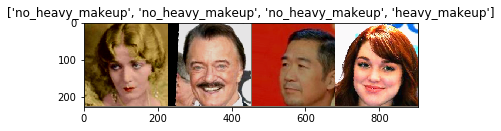

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
Now, let’s write a general function to train a model. Here, we will illustrate:

Scheduling the learning rate
Saving the best model
In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    acc = {
        'train': [],
        'val': []
    }
    loss_list = {
        'train': [],
        'val': []
    }


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)                            
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            acc[phase].append(epoch_acc)
            loss_list[phase].append(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, acc, loss_list

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
def plot_acc_loss(acc, loss, title, acc_color=None, loss_color=None):
  plt.plot(list(range(len(acc['train']))), acc['train'], color=acc_color)
  plt.plot(list(range(len(acc['val']))), acc['val'], color=acc_color)
  plt.xlabel('epoch')
  plt.ylabel('acc')
  plt.legend(['train_acc', 'val_acc'])
  plt.title(title)
  plt.show()
  plt.plot(list(range(len(loss['train']))), loss['train'], color=loss_color)
  plt.plot(list(range(len(loss['val']))), loss['val'], color=loss_color)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train_loss', 'val_loss'])
  plt.title(title)
  plt.show()

In [0]:
reset()

In [11]:
## Resnet
model_ft = models.resnet50(pretrained=True)
model_ft.fc = nn.Linear(2048, 2)
print(model_ft)
##

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# step size could be
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 50.0MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
model_ft, model_ft_acc, model_ft_loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6198 Acc: 0.7495
val Loss: 0.3644 Acc: 0.8425

Epoch 1/24
----------
train Loss: 0.4311 Acc: 0.8180
val Loss: 0.2551 Acc: 0.9025

Epoch 2/24
----------
train Loss: 0.4118 Acc: 0.8435
val Loss: 0.3372 Acc: 0.8525

Epoch 3/24
----------
train Loss: 0.3500 Acc: 0.8630
val Loss: 0.3088 Acc: 0.8825

Epoch 4/24
----------
train Loss: 0.2900 Acc: 0.8930
val Loss: 0.3666 Acc: 0.8200

Epoch 5/24
----------
train Loss: 0.1776 Acc: 0.9355
val Loss: 0.2486 Acc: 0.8875

Epoch 6/24
----------
train Loss: 0.1593 Acc: 0.9395
val Loss: 0.2628 Acc: 0.8925

Epoch 7/24
----------
train Loss: 0.1428 Acc: 0.9465
val Loss: 0.2505 Acc: 0.8975

Epoch 8/24
----------
train Loss: 0.1340 Acc: 0.9500
val Loss: 0.2626 Acc: 0.8925

Epoch 9/24
----------
train Loss: 0.1274 Acc: 0.9565
val Loss: 0.2704 Acc: 0.8975

Epoch 10/24
----------
train Loss: 0.1214 Acc: 0.9550
val Loss: 0.2689 Acc: 0.8975

Epoch 11/24
----------
train Loss: 0.1137 Acc: 0.9600
val Loss: 0.2659 Acc: 0.8975

Ep

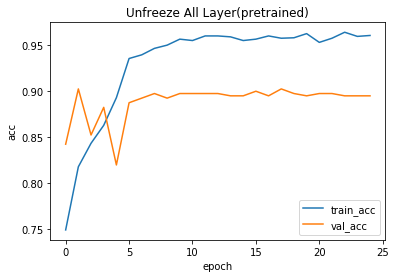

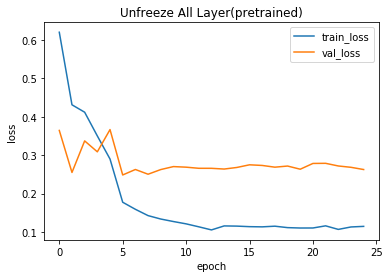

In [13]:
plot_acc_loss(model_ft_acc, model_ft_loss, 'Unfreeze All Layer(pretrained)')

**Visualizing the model predictions:**

1.   List item
2.   List item


Generic function to display predictions for a few images

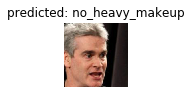

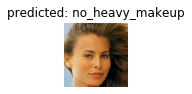

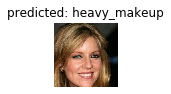

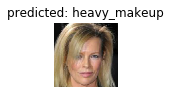

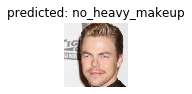

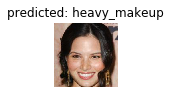

In [14]:
visualize_model(model_ft)